In [16]:
from typing import List, Tuple, Dict, TypedDict, Optional
import numpy as np
import cv2
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from numpy.typing import NDArray

class Measurement(TypedDict):
    point: Tuple[int, int]  # (x, y) coordinate
    width: float           # distance to nearest edge

Point = Tuple[int, int]
Path = List[Point]

def trace_skeleton_paths(skeleton: NDArray[np.uint8]) -> List[Path]:
    """
    Trace paths along skeleton to get continuous road centerlines.
    
    Args:
        skeleton: Binary image of the road skeleton
        
    Returns:
        List of paths, where each path is a list of (y, x) coordinates
    """
    paths: List[Path] = []
    visited: NDArray[np.bool_] = np.zeros_like(skeleton, dtype=bool)
    
    def get_neighbors(y: int, x: int) -> List[Point]:
        neighbors: List[Point] = []
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dy == 0 and dx == 0:
                    continue
                ny, nx = y + dy, x + dx
                if (0 <= ny < skeleton.shape[0] and 
                    0 <= nx < skeleton.shape[1] and 
                    skeleton[ny, nx] > 0 and 
                    not visited[ny, nx]):
                    neighbors.append((ny, nx))
        return neighbors
    
    def trace_path(start_y: int, start_x: int) -> Path:
        path: Path = [(start_y, start_x)]
        visited[start_y, start_x] = True
        
        while True:
            neighbors = get_neighbors(path[-1][0], path[-1][1])
            if not neighbors:
                break
            path.append(neighbors[0])
            visited[neighbors[0][0], neighbors[0][1]] = True
        
        return path
    
    # Find all paths
    y_coords, x_coords = np.where(skeleton > 0)
    for y, x in zip(y_coords, x_coords):
        if not visited[y, x]:
            path = trace_path(y, x)
            if len(path) > 1:  # Only keep paths with more than one point
                paths.append(path)
    
    return paths

def measure_road_widths(
    binary_image: NDArray[np.uint8], 
    sampling_interval: int = 10
) -> Tuple[List[Measurement], NDArray[np.uint8], List[Path]]:
    """
    Measure road widths from centerline to edge at regular intervals.
    
    Args:
        binary_image: Binary image where roads are white (255) and background is black (0)
        sampling_interval: Number of pixels between measurements along the centerline
        
    Returns:
        Tuple containing:
        - List of measurements (point coordinates and widths)
        - Skeleton image
        - List of centerline paths
    """
    # Ensure image is binary
    _, binary = cv2.threshold(binary_image, 127, 255, cv2.THRESH_BINARY)
    
    # Get skeleton (centerline)
    skeleton = skeletonize(binary.astype(bool))
    skeleton = (skeleton * 255).astype(np.uint8)
    
    # Trace paths along the skeleton
    paths = trace_skeleton_paths(skeleton)
    
    # Get distance transform of the road mask
    dist_transform: NDArray[np.float32] = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    
    measurements: List[Measurement] = []
    
    # For each path
    for path in paths:
        # Sample points along the path
        for i in range(0, len(path), sampling_interval):
            y, x = path[i]
            width = float(dist_transform[y, x])  # Convert to float for type consistency
            measurements.append({
                'point': (x, y),
                'width': width
            })
    
    return measurements, skeleton, paths

def visualize_road_widths_with_centerline(
    binary_image: NDArray[np.uint8],
    measurements: List[Measurement],
    paths: List[Path]
) -> plt.Figure:
    """
    Visualize road width measurements and centerline.
    
    Args:
        binary_image: Original binary image
        measurements: List of width measurements and their locations
        paths: List of centerline paths
        
    Returns:
        Matplotlib figure containing the visualization
    """
    # Create RGB visualization
    vis_image = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2RGB)
    
    fig = plt.figure(figsize=(15, 15))
    
    # Show the binary image
    plt.imshow(vis_image)
    
    # Plot each centerline path
    for path in paths:
        path_array = np.array(path)
        plt.plot(path_array[:, 1], path_array[:, 0], 'r-', linewidth=1)
    
    # Plot measurement points and widths
    for measure in measurements:
        x, y = measure['point']
        width = measure['width']
        
        # Draw measurement point
        plt.plot(x, y, 'yo', markersize=3)
        
        # Add width label
        plt.text(x, y, f'{width:.1f}', 
                color='white', 
                backgroundcolor='black',
                ha='center', 
                va='bottom', 
                fontsize=8)
    
    plt.axis('off')
    plt.title('Road Width Measurements with Centerline')
    plt.tight_layout()
    return fig

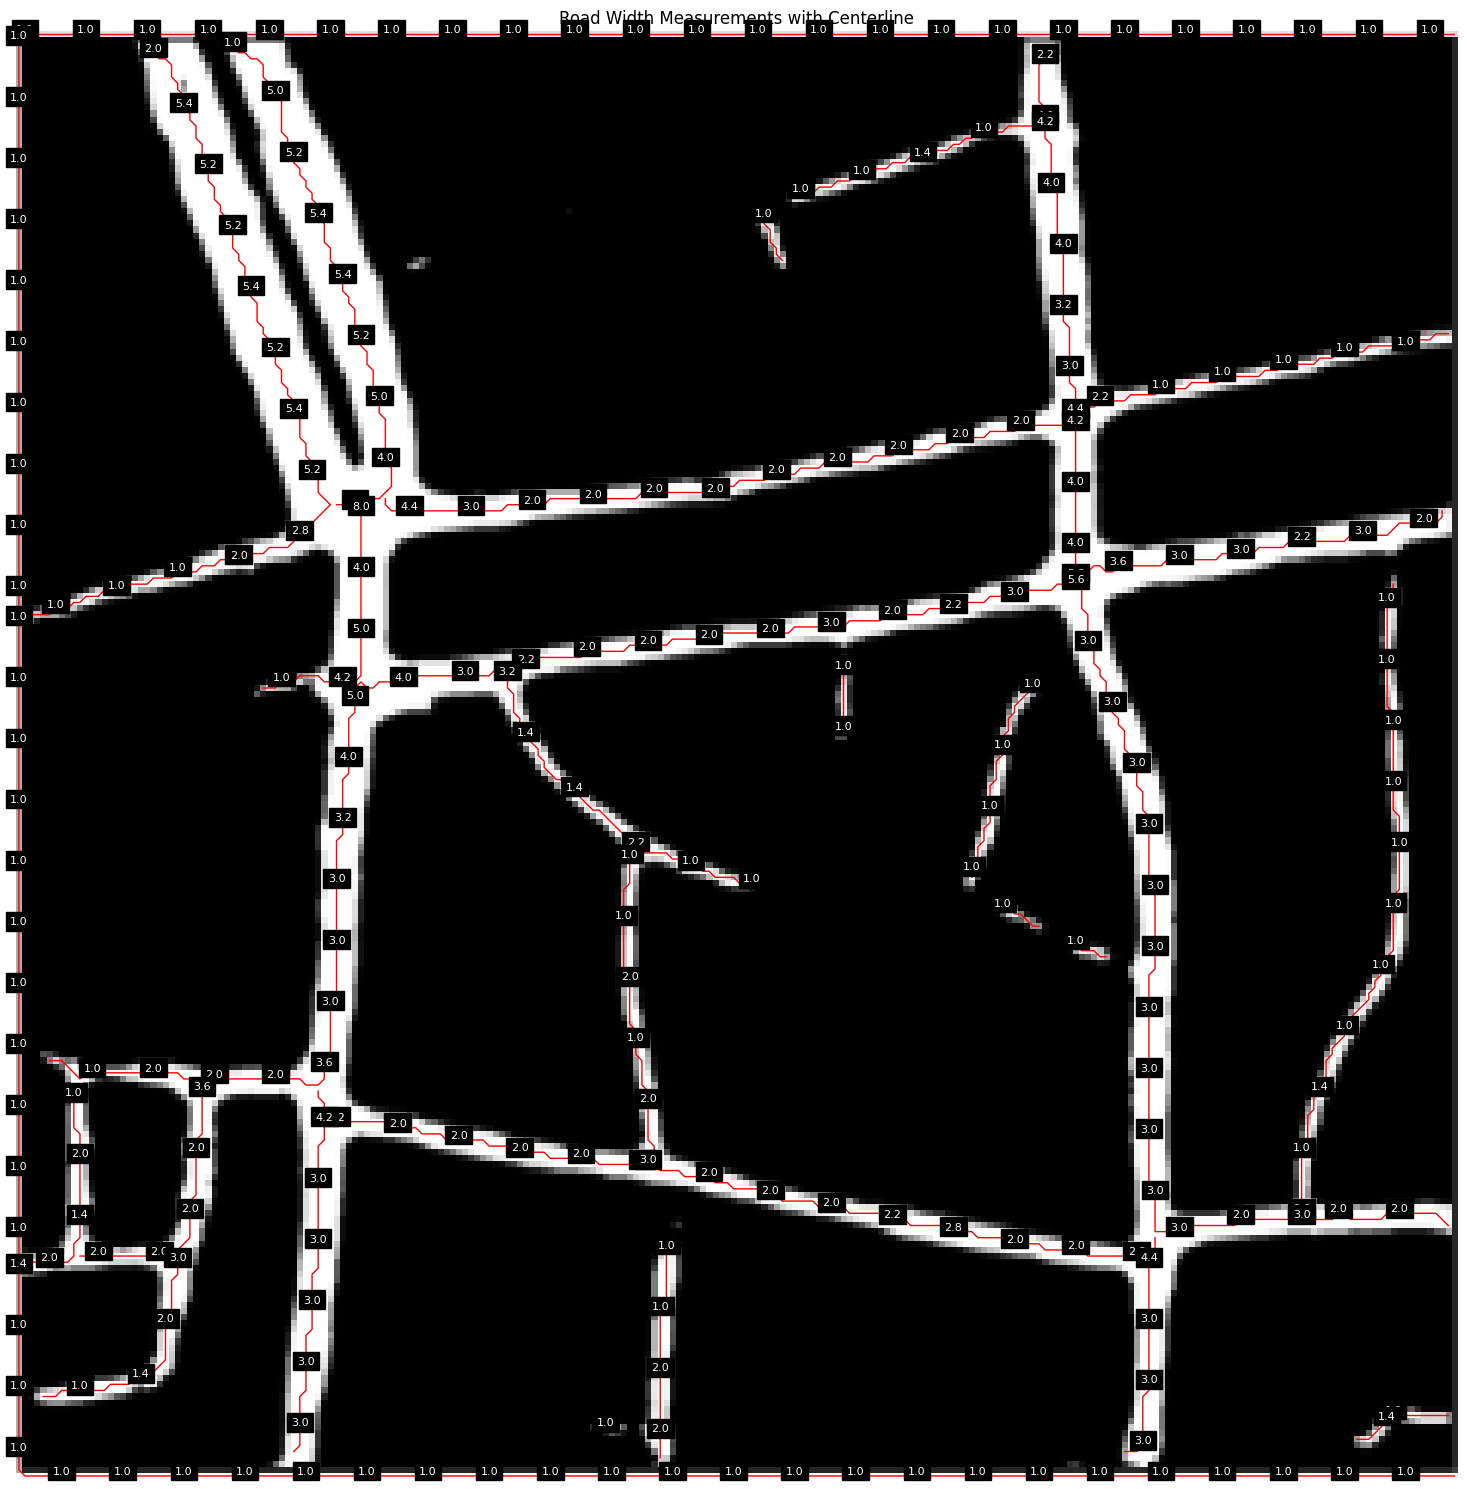

In [17]:
binary_image = cv2.imread('data/test_samples/Screenshot 2024-12-19 215319.png', cv2.IMREAD_GRAYSCALE)

# Measure road widths and get paths
measurements, skeleton, paths = measure_road_widths(binary_image, sampling_interval=10)

# Visualize with proper centerline
fig = visualize_road_widths_with_centerline(binary_image, measurements, paths)
plt.show()

In [18]:
# Print some statistics
widths = [m['width'] for m in measurements]
print(f"Average road width: {np.mean(widths):.2f} pixels")
print(f"Min width: {np.min(widths):.2f} pixels")
print(f"Max width: {np.max(widths):.2f} pixels")

Average road width: 2.12 pixels
Min width: 1.00 pixels
Max width: 8.00 pixels
